<a href="https://colab.research.google.com/github/RishabhL7/Model_Comparison/blob/main/DLV3_recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [39]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
from tqdm import tqdm

from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tqdm import tqdm 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam

In [3]:
IMG_WIDTH = 320
IMG_HEIGHT = 320
IMG_CHANNELS = 3

#READING THE IMAGE AND LABEL FOR FINAL RECOGNITION

In [4]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#Onehot Encoding the labels.
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [5]:
!unzip '/content/drive/MyDrive/Dataset.zip'

Archive:  /content/drive/MyDrive/Dataset.zip
   creating: Complete/
  inflating: Complete/A-1.jpg        
  inflating: Complete/A-10.jpg       
  inflating: Complete/A-100.jpg      
  inflating: Complete/A-11.jpg       
  inflating: Complete/A-12.jpg       
  inflating: Complete/A-13.jpg       
  inflating: Complete/A-14.jpg       
  inflating: Complete/A-15.jpg       
  inflating: Complete/A-16.jpg       
  inflating: Complete/A-17.jpg       
  inflating: Complete/A-18.jpg       
  inflating: Complete/A-19.jpg       
  inflating: Complete/A-2.jpg        
  inflating: Complete/A-20.jpg       
  inflating: Complete/A-21.jpg       
  inflating: Complete/A-22.jpg       
  inflating: Complete/A-23.jpg       
  inflating: Complete/A-24.jpg       
  inflating: Complete/A-25.jpg       
  inflating: Complete/A-26.jpg       
  inflating: Complete/A-27.jpg       
  inflating: Complete/A-28.jpg       
  inflating: Complete/A-29.jpg       
  inflating: Complete/A-3.jpg        
  inflating: Complet

In [6]:
path = "/content/Complete"

x_train = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
y_train = []
print('creating train data for recognition ( Only color images and respective labels)')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_train[n]=img

    #labels
    heads, tails = os.path.split(newpath)
    y_train.append(tails[0])
    n+=1

creating train data for recognition ( Only color images and respective labels)


100%|██████████| 1000/1000 [03:34<00:00,  4.66it/s]


In [7]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)

In [8]:
y_train=to_categorical(y_train)

xtrain_shape (1000, 320, 320, 3)
y_train_shape (1000, 10)


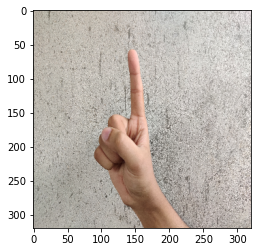

In [9]:
plt.imshow(array_to_img(x_train[0]))
print("xtrain_shape", x_train.shape)
print("y_train_shape",y_train.shape)

In [10]:
y_train[0]


array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

#SEGMENTATION MODEL

In [11]:
#Import necessary libraries

import keras

import tensorflow as tf
from keras.datasets import mnist

from keras.models import Model,Input

from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,AveragePooling2D,Dropout,BatchNormalization,Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K

In [12]:
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Dropout
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate, Conv2DTranspose, Add, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *

#RECOGNITION MODEL

In [ ]:
# LATEST MODEL - LINKNET only

def build_LinkNet_mobilenetv2():    
  model = tf.keras.applications.MobileNetV2(input_shape=(320, 320,3), include_top=False, weights="imagenet")

  """ Skip Connections """

  s1 = model.get_layer("block_1_expand_relu").output         ## (160, 160)
  s2 = model.get_layer("block_3_expand_relu").output         ## ( 80, 80)
  s3 = model.get_layer("block_6_expand_relu").output         ## (40, 40)
  s4 = model.get_layer("block_13_expand_relu").output         ## (20, 20)

  #print(s1.shape, s2.shape, s3.shape, s4.shape)

  """ Bridge """

  b1 = model.get_layer("out_relu").output
  #print(b1.shape)

  """ Decoder """
  x = Conv2D(320, (1,1), kernel_initializer='he_normal', padding = 'same')(b1)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(320, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(576, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s4]) # ADD 1

  x = Conv2D(144, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(144, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(192, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s3]) # ADD 2

  x = Conv2D(48, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(48, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(144, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s2]) # ADD 3

  x = Conv2D(36, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(36, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(96, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s1]) # ADD 4

  x = Conv2D(24, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(24, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(16, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  
  x = Dropout(0.15)(x)
  outputs = Conv2D(1, 1, kernel_initializer='he_normal',padding="same")(x)
  outputs = Activation('sigmoid')(outputs)

  model = keras.models.Model(inputs=[model.input], outputs=[outputs])  

  #print(model.summary())

  return model

In [40]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size=320):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    x = layers.Conv2D(1,1)(x)
    x = keras.layers.Activation("sigmoid")(x)

    model = keras.Model(inputs=model_input, outputs=x)
    
    return model

In [41]:
from keras.layers import Dense, Dropout, Activation, \
                         Flatten, Convolution2D, MaxPooling2D, \
                         BatchNormalization, Conv2D, Input,merge,AveragePooling2D,concatenate
from keras.models import Model

In [42]:
# Recognition Model

class RecModel(object):
        def __init__(self, input_size,num_class):
            self.input_size=input_size
            self.num_class=num_class

            self._build_model()

        def _build_model(self):
                Smodel=DeeplabV3Plus()
                checkpoint_path_segmentUNET = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/deeplabv3plus_500_new/cp.ckpt"
                Smodel.load_weights(checkpoint_path_segmentUNET)
                l=len(Smodel.layers)
                for layer in Smodel.layers[:l]:
                    layer.trainable = False

                inp = Input(shape=self.input_size)
                inp_stream1=Smodel.input
                inp_stram2 = Smodel.output

                ###Stream1------------------

                x = Conv2D(16, 3, activation = 'relu', padding = 'same' ,dilation_rate=1,name='CV1')(inp_stream1)
                x = MaxPooling2D(pool_size=(3, 3))(x)

                x = Conv2D(32, 3, activation = 'relu', padding = 'same',dilation_rate=2,name='CV2')(x)
                x = MaxPooling2D(pool_size=(3, 3))(x)

                x = Conv2D(64, 3, activation = 'relu', padding = 'same',dilation_rate=2,name='CV4')(x)
                x = MaxPooling2D(pool_size=(3, 3))(x)

                x = Conv2D(128, 3, activation = 'relu', padding = 'same',dilation_rate=3,name='CV41')(x)
                xf1 = MaxPooling2D(pool_size=(3, 3))(x)
              
                ###Stream2--------------------

                x1 = Conv2D(16, 3, activation = 'relu', padding = 'same',dilation_rate=1,name='CV11')(inp_stram2)
                x1 = MaxPooling2D(pool_size=(3, 3))(x1)

                x1 = Conv2D(32, 3, activation = 'relu', padding = 'same',dilation_rate=2,name='CV421')(x1)
                x1 = MaxPooling2D(pool_size=(3, 3))(x1)

                x1 = Conv2D(64, 3, activation = 'relu', padding = 'same',dilation_rate=2 ,name='CV31')(x1)
                x1 = MaxPooling2D(pool_size=(3, 3))(x1)

                x1 = Conv2D(128, 3, activation = 'relu', padding = 'same',dilation_rate=3,name='CV412')(x1)
                xf2 = MaxPooling2D(pool_size=(3, 3))(x1)

                ####--------
                f = keras.layers.concatenate([xf1,xf2], axis = 3) 
                f = MaxPooling2D(pool_size=(3, 3))(f)


                f = Flatten()(f)

                f = Dropout(0.2)(f)

                prediction = Dense(self.num_class, activation="softmax")(f)
                model_final = Model(Smodel.input, prediction)
                                                    


                self.model_F=model_final

In [43]:
input_size = (320,320,3)
num_class = 10
RecM=RecModel((320,320,3), 10)
model=RecM.model_F
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

# **WITHOUT DATA AUGMENTATION**

Check if the model gives any value of accuracy without fitting it first


In [44]:
_adam = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    decay=0.0
)
model.compile(loss='binary_crossentropy',optimizer = _adam,metrics=['accuracy'])


In [45]:
y_debug_pred = model.predict(x_train)

In [46]:
np.argmax(y_debug_pred[0])

0

In [47]:
model.evaluate(x_train, y_train)

32/32 [==============================] - 9s 190ms/step - loss: 3.2567 - accuracy: 0.0720


[3.2567310333251953, 0.07199999690055847]

Model predict is giving a value
NOW WE FIT THE DATA

In [48]:
path = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_DLV3"
os.mkdir(path)

In [49]:
#Model Checkpoint
checkpoint_path_recog_augmentation = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_DLV3/cp.ckpt"
model_checkpoint_recog_augmentation = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_recog_augmentation,
                                                 save_weights_only=True,
                                                  monitor='val_accuracy',save_best_only=True,
                                                 verbose=1)

In [50]:
history = model.fit(x_train, y_train, batch_size=2, epochs=50,validation_split=0.1, callbacks=[model_checkpoint_recog_augmentation])

450/450 [==============================] - ETA: 0s - loss: 0.2363 - accuracy: 0.6000
Epoch 1: val_accuracy improved from -inf to 0.97000, saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_DLV3/cp.ckpt
450/450 [==============================] - 23s 34ms/step - loss: 0.2363 - accuracy: 0.6000 - val_loss: 0.0311 - val_accuracy: 0.9700
Epoch 2/50
449/450 [============================>.] - ETA: 0s - loss: 0.0341 - accuracy: 0.9621
Epoch 2: val_accuracy improved from 0.97000 to 1.00000, saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_DLV3/cp.ckpt
450/450 [==============================] - 13s 30ms/step - loss: 0.0340 - accuracy: 0.9622 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 3/50
449/450 [============================>.] - ETA: 0s - loss: 0.0179 - accuracy: 0.9889
Epoch 3: val_accuracy did not improve from 1.00000
450/450 [==============================] - 14s 32ms/step - loss: 0.0179 - accuracy: 0.9889 - val_loss: 0.0233 - val_a

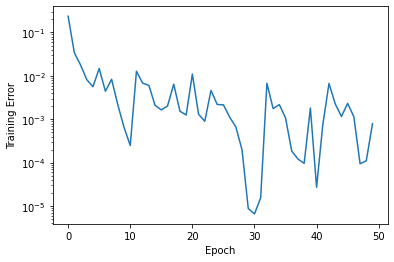

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.savefig('UNET_Traininerrorplot_UNAUGMENTED.png')

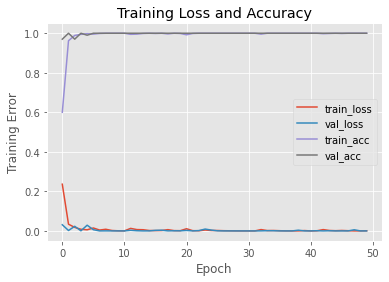

In [52]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 50
plt.plot(np.arange(0,N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), history.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), history.history["accuracy"], label = "train_acc")
plt.plot(np.arange(0,N), history.history["val_accuracy"], label = "val_acc")
plt.legend(loc="center right")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.savefig('UNET_Traininerrorplot_RECOGNITION_Unaugmented.png')

#SAVE THE MODEL

In [53]:
model.save('/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_DLV3/Data.h5')
model.save_weights('/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_DLV3/Data_weights.h5')

#Test Data

In [54]:
!unzip '/content/drive/MyDrive/Testset.zip'

Archive:  /content/drive/MyDrive/Testset.zip
   creating: Testset/
 extracting: Testset/A-1.jpg         
 extracting: Testset/A-10.jpg        
 extracting: Testset/A-2.jpg         
 extracting: Testset/A-3.jpg         
 extracting: Testset/A-4.jpg         
 extracting: Testset/A-5.jpg         
 extracting: Testset/A-6.jpg         
 extracting: Testset/A-7.jpg         
 extracting: Testset/A-8.jpg         
 extracting: Testset/A-9.jpg         
 extracting: Testset/B-1.jpg         
 extracting: Testset/B-10.jpg        
 extracting: Testset/B-2.jpg         
 extracting: Testset/B-3.jpg         
 extracting: Testset/B-4.jpg         
 extracting: Testset/B-5.jpg         
 extracting: Testset/B-6.jpg         
 extracting: Testset/B-7.jpg         
 extracting: Testset/B-8.jpg         
 extracting: Testset/B-9.jpg         
 extracting: Testset/C-1.jpg         
 extracting: Testset/C-10.jpg        
 extracting: Testset/C-2.jpg         
 extracting: Testset/C-3.jpg         
 extracting: Testset/

In [55]:
path = '/content/Testset'

x_test = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
y_test = []
print('creating test data for recognition ( Only color images and respective labels)')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_test[n]=img

    #labels
    heads, tails = os.path.split(newpath)
    y_test.append(tails[0])
    n+=1

creating test data for recognition ( Only color images and respective labels)


100%|██████████| 100/100 [00:00<00:00, 174.00it/s]


In [56]:
y_test

['D',
 'B',
 'H',
 'A',
 'J',
 'G',
 'I',
 'B',
 'I',
 'G',
 'F',
 'A',
 'D',
 'J',
 'G',
 'H',
 'B',
 'I',
 'A',
 'I',
 'E',
 'C',
 'D',
 'B',
 'B',
 'F',
 'F',
 'E',
 'J',
 'A',
 'I',
 'H',
 'J',
 'G',
 'F',
 'E',
 'C',
 'C',
 'I',
 'E',
 'A',
 'I',
 'A',
 'I',
 'D',
 'E',
 'C',
 'A',
 'E',
 'J',
 'D',
 'C',
 'J',
 'C',
 'J',
 'F',
 'I',
 'B',
 'F',
 'A',
 'F',
 'H',
 'F',
 'B',
 'B',
 'B',
 'C',
 'G',
 'H',
 'D',
 'H',
 'J',
 'E',
 'D',
 'J',
 'G',
 'C',
 'F',
 'H',
 'E',
 'D',
 'C',
 'F',
 'H',
 'G',
 'E',
 'G',
 'G',
 'A',
 'D',
 'C',
 'A',
 'I',
 'J',
 'G',
 'H',
 'E',
 'H',
 'B',
 'D']

In [57]:
le = preprocessing.LabelEncoder()
y_test = le.fit_transform(y_test)

In [58]:
y_test

array([3, 1, 7, 0, 9, 6, 8, 1, 8, 6, 5, 0, 3, 9, 6, 7, 1, 8, 0, 8, 4, 2,
       3, 1, 1, 5, 5, 4, 9, 0, 8, 7, 9, 6, 5, 4, 2, 2, 8, 4, 0, 8, 0, 8,
       3, 4, 2, 0, 4, 9, 3, 2, 9, 2, 9, 5, 8, 1, 5, 0, 5, 7, 5, 1, 1, 1,
       2, 6, 7, 3, 7, 9, 4, 3, 9, 6, 2, 5, 7, 4, 3, 2, 5, 7, 6, 4, 6, 6,
       0, 3, 2, 0, 8, 9, 6, 7, 4, 7, 1, 3])

In [59]:
print(x_test.shape)
print(y_test.shape)

(100, 320, 320, 3)
(100,)


In [60]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [70]:
 #    ######evaluate#####
checkpoint_path_recog = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_DLV3/Data_weights.h5"
model.load_weights(checkpoint_path_recog)




In [71]:
y_pred=model.predict(x_test)

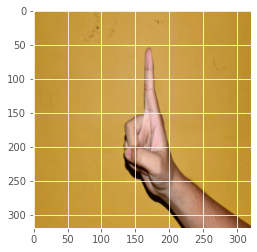

In [72]:
plt.imshow(array_to_img(x_test[5]))

In [73]:
y_classes = [np.argmax(i) for i in y_pred]

In [74]:
y_classes[:5]

[3, 1, 7, 0, 9]

In [75]:
y_test[:5]

array([3, 1, 7, 0, 9])

In [76]:
print("Classification Report: \n", classification_report(y_test, y_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.77      1.00      0.87        10
           2       0.91      1.00      0.95        10
           3       0.75      0.90      0.82        10
           4       1.00      1.00      1.00        10
           5       1.00      0.70      0.82        10
           6       0.91      1.00      0.95        10
           7       0.91      1.00      0.95        10
           8       1.00      1.00      1.00        10
           9       1.00      0.80      0.89        10

    accuracy                           0.91       100
   macro avg       0.92      0.91      0.91       100
weighted avg       0.92      0.91      0.91       100



Text(69.0, 0.5, 'Truth')

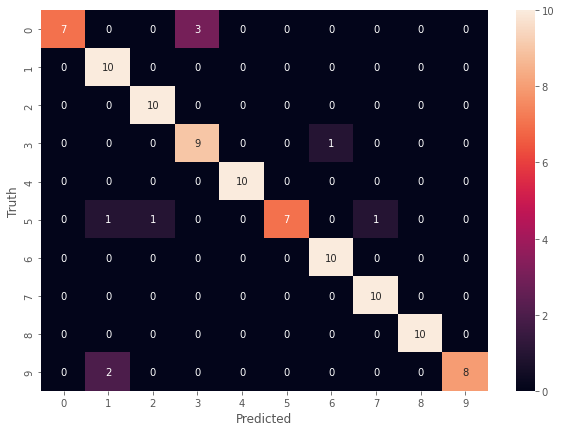

In [77]:
cm = confusion_matrix(y_test, y_classes)
#Visualising Confusion Matrix using seaborn
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [78]:
print("F1-Score", f1_score(y_test, y_classes, average='macro'))

F1-Score 0.9080837605134281
